In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds

# Define seed and fixed variables
seed = 42
keras.utils.set_random_seed(seed)
AUTO = tf.data.AUTOTUNE

2025-11-17 14:12:21.123556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Specify dataset parameters
dataset_name = "tf_flowers"
batch_size = 64
image_size = (224, 224)

# Load data from tfds and split 10% off for a test set
(train_data, test_data), ds_info = tfds.load(
    dataset_name,
    split=["train[:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Extract number of classes and list of class names
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


# Convert datasets to NumPy arrays
def dataset_to_array(dataset, image_size, num_classes):
    images, labels = [], []
    for img, lab in dataset.as_numpy_iterator():
        images.append(tf.image.resize(img, image_size).numpy())
        labels.append(tf.one_hot(lab, num_classes))
    return np.array(images), np.array(labels)


img_train, label_train = dataset_to_array(train_data, image_size, num_classes)
img_test, label_test = dataset_to_array(test_data, image_size, num_classes)

num_train_samples = len(img_train)
print(f"Number of training samples: {num_train_samples}")

I0000 00:00:1763385146.731726   13595 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8977 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


2025-11-17 14:12:27.545757: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-17 14:12:33.066355: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of training samples: 3303


2025-11-17 14:12:33.973401: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


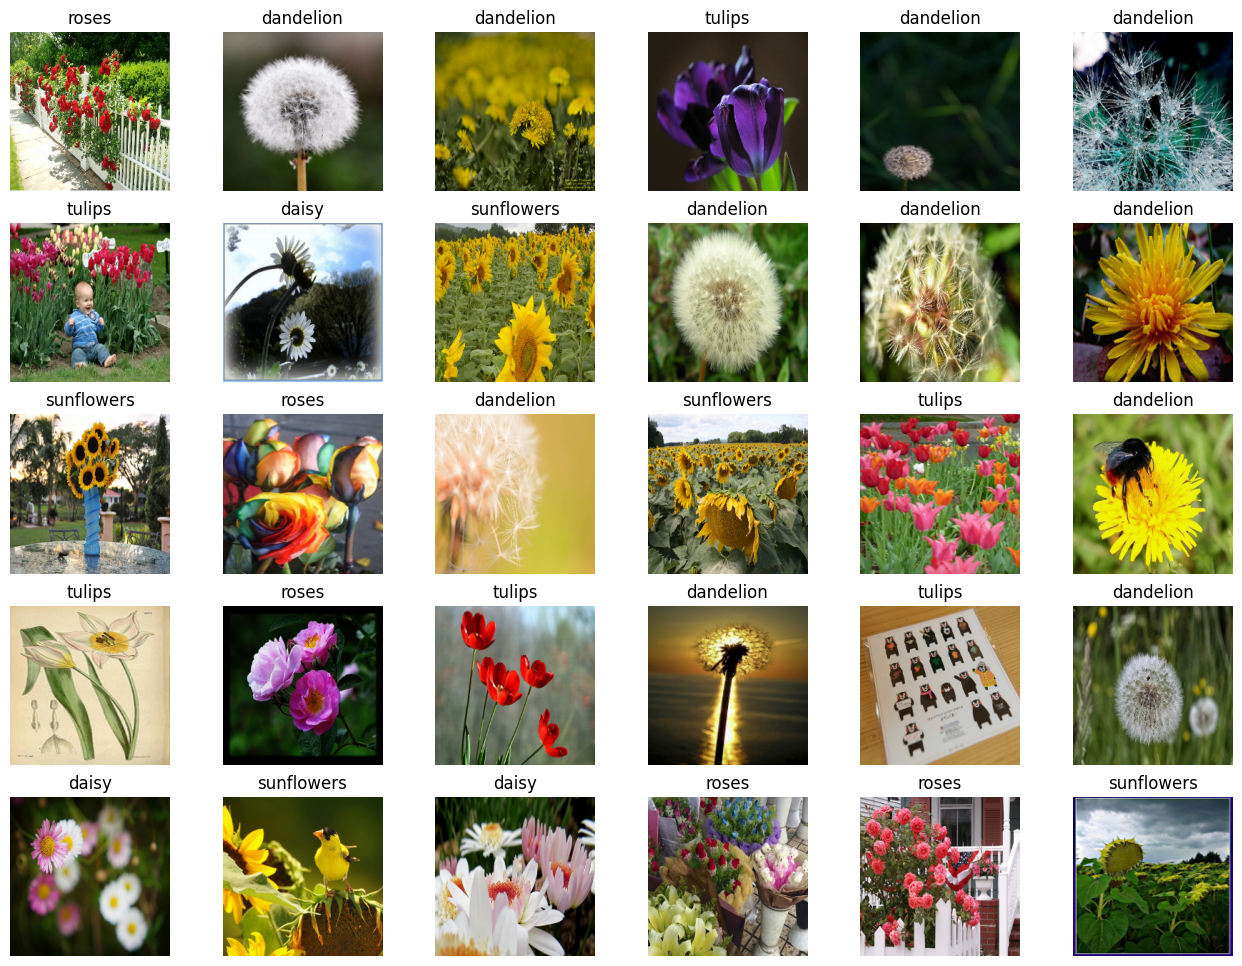

In [3]:
plt.figure(figsize=(16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    plt.imshow(img_test[n].astype("uint8"))
    plt.title(np.array(class_names)[label_test[n] == True][0])
    plt.axis("off")

In [4]:
# Define image augmentation model
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0)),
        layers.RandomContrast(factor=0.1),
    ],
)

# Apply the augmentations to the training images and plot a few examples
img_train = image_augmentation(img_train).numpy()

plt.figure(figsize=(16, 12))
for n in range(10):
    ax = plt.subplot(5, 2, n + 1)
    plt.imshow(img_train[n].astype("uint8"))
    plt.title(np.array(class_names)[label_train[n] == True][0])
    plt.axis("off")

2025-11-17 14:12:51.915860: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.85GiB (rounded to 1988775936)requested by op ImageProjectiveTransformV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-17 14:12:51.915877: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-11-17 14:12:51.915884: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 36, Chunks in use: 36. 9.0KiB allocated for chunks. 9.0KiB in use in bin. 280B client-requested in use in bin.
2025-11-17 14:12:51.915888: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-11-

ResourceExhaustedError: Exception encountered when calling RandomZoom.call().

[1m{{function_node __wrapped__ImageProjectiveTransformV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3303,224,224,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node ImageProjectiveTransformV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:ImageProjectiveTransformV3] name: [0m

Arguments received by RandomZoom.call():
  • data=tf.Tensor(shape=(3303, 224, 224, 3), dtype=float32)
  • training=True

In [5]:
def build_model(num_classes, img_size=image_size[0], top_dropout=0.3):
    """Creates a classifier based on pre-trained MobileNetV2.

    Arguments:
        num_classes: Int, number of classese to use in the softmax layer.
        img_size: Int, square size of input images (defaults is 224).
        top_dropout: Int, value for dropout layer (defaults is 0.3).

    Returns:
        Uncompiled Keras model.
    """

    # Create input and pre-processing layers for MobileNetV2
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    model = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_tensor=x
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dropout(top_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    print("Trainable weights:", len(model.trainable_weights))
    print("Non_trainable weights:", len(model.non_trainable_weights))
    return model


def compile_and_train(
    model,
    training_data,
    training_labels,
    metrics=[keras.metrics.AUC(name="auc"), "acc"],
    optimizer=keras.optimizers.Adam(),
    patience=5,
    epochs=5,
):
    """Compiles and trains the model.

    Arguments:
        model: Uncompiled Keras model.
        training_data: NumPy Array, training data.
        training_labels: NumPy Array, training labels.
        metrics: Keras/TF metrics, requires at least 'auc' metric (default is
                `[keras.metrics.AUC(name='auc'), 'acc']`).
        optimizer: Keras/TF optimizer (defaults is `keras.optimizers.Adam()).
        patience: Int, epochsfor EarlyStopping patience (defaults is 5).
        epochs: Int, number of epochs to train (default is 5).

    Returns:
        Training history for trained Keras model.
    """

    stopper = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        min_delta=0,
        patience=patience,
        verbose=1,
        restore_best_weights=True,
    )

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics)

    history = model.fit(
        x=training_data,
        y=training_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[stopper],
    )
    return history


def unfreeze(model, block_name, verbose=0):
    """Unfreezes Keras model layers.

    Arguments:
        model: Keras model.
        block_name: Str, layer name for example block_name = 'block4'.
                    Checks if supplied string is in the layer name.
        verbose: Int, 0 means silent, 1 prints out layers trainability status.

    Returns:
        Keras model with all layers after (and including) the specified
        block_name to trainable, excluding BatchNormalization layers.
    """

    # Unfreeze from block_name onwards
    set_trainable = False

    for layer in model.layers:
        if block_name in layer.name:
            set_trainable = True
        if set_trainable and not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            if verbose == 1:
                print(layer.name, "trainable")
        else:
            if verbose == 1:
                print(layer.name, "NOT trainable")
    print("Trainable weights:", len(model.trainable_weights))
    print("Non-trainable weights:", len(model.non_trainable_weights))
    return model

In [6]:
def train_model(training_data, training_labels):
    """Trains the model as follows:

    - Trains only the top layers for 10 epochs.
    - Unfreezes deeper layers.
    - Train for 20 more epochs.

    Arguments:
        training_data: NumPy Array, training data.
        training_labels: NumPy Array, training labels.

    Returns:
        Model accuracy.
    """

    model = build_model(num_classes)

    # Compile and train top layers
    history = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics=[keras.metrics.AUC(name="auc"), "acc"],
        optimizer=keras.optimizers.Adam(),
        patience=3,
        epochs=10,
    )

    # Unfreeze model from block 10 onwards
    model = unfreeze(model, "block_10")

    # Compile and train for 20 epochs with a lower learning rate
    fine_tune_epochs = 20
    total_epochs = history.epoch[-1] + fine_tune_epochs

    history_fine = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics=[keras.metrics.AUC(name="auc"), "acc"],
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        patience=5,
        epochs=total_epochs,
    )

    # Calculate model accuracy on the test set
    _, _, acc = model.evaluate(img_test, label_test)
    return np.round(acc, 4)

In [7]:
def train_iteratively(sample_splits=[0.05, 0.1, 0.25, 0.5], iter_per_split=5):
    """Trains a model iteratively over several sample splits.

    Arguments:
        sample_splits: List/NumPy array, contains fractions of the trainins set
                        to train over.
        iter_per_split: Int, number of times to train a model per sample split.

    Returns:
        Training accuracy for all splits and iterations and the number of samples
        used for training at each split.
    """
    # Train all the sample models and calculate accuracy
    train_acc = []
    sample_sizes = []

    for fraction in sample_splits:
        print(f"Fraction split: {fraction}")
        # Repeat training 3 times for each sample size
        sample_accuracy = []
        num_samples = int(num_train_samples * fraction)
        for i in range(iter_per_split):
            print(f"Run {i+1} out of {iter_per_split}:")
            # Create fractional subsets
            rand_idx = np.random.randint(num_train_samples, size=num_samples)
            train_img_subset = img_train[rand_idx, :]
            train_label_subset = label_train[rand_idx, :]
            # Train model and calculate accuracy
            accuracy = train_model(train_img_subset, train_label_subset)
            print(f"Accuracy: {accuracy}")
            sample_accuracy.append(accuracy)
        train_acc.append(sample_accuracy)
        sample_sizes.append(num_samples)
    return train_acc, sample_sizes


# Running the above function produces the following outputs
train_acc = [
    [0.8202, 0.7466, 0.8011, 0.8447, 0.8229],
    [0.861, 0.8774, 0.8501, 0.8937, 0.891],
    [0.891, 0.9237, 0.8856, 0.9101, 0.891],
    [0.8937, 0.9373, 0.9128, 0.8719, 0.9128],
]

sample_sizes = [165, 330, 825, 1651]

Curve fit weights: a = 0.6445640325546265 and b = 0.04809745401144028.
A model accuracy of 0.9517362117767334 is predicted for 3303 samples.


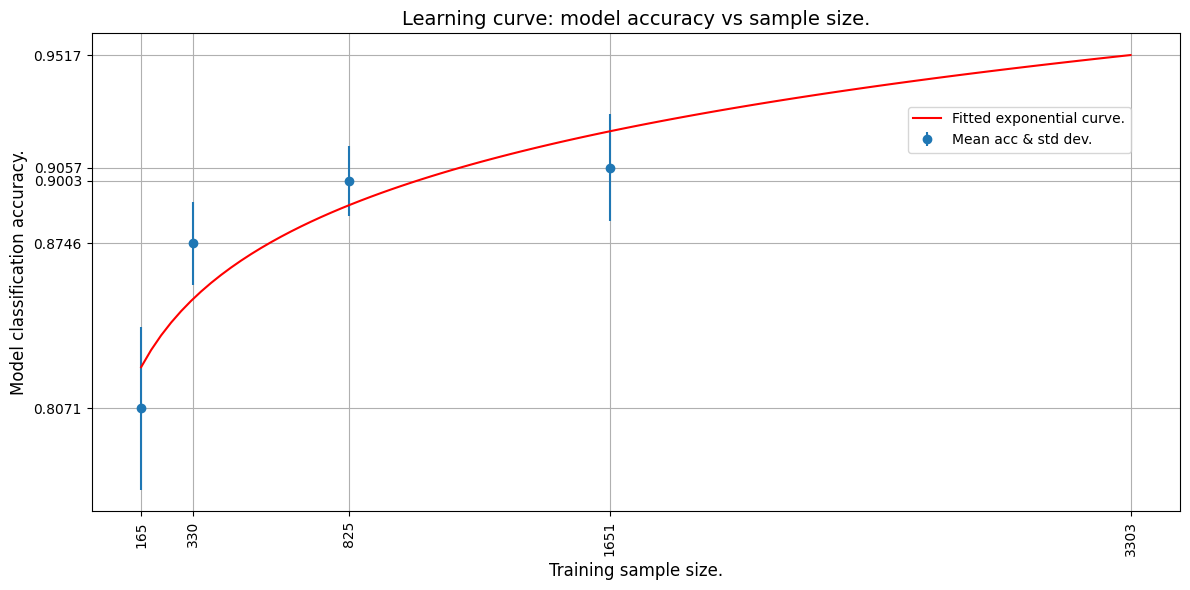

The mae for the curve fit is 0.016098752617836.


In [8]:
def fit_and_predict(train_acc, sample_sizes, pred_sample_size):
    """Fits a learning curve to model training accuracy results.

    Arguments:
        train_acc: List/Numpy Array, training accuracy for all model
                    training splits and iterations.
        sample_sizes: List/Numpy array, number of samples used for training at
                    each split.
        pred_sample_size: Int, sample size to predict model accuracy based on
                        fitted learning curve.
    """
    x = sample_sizes
    mean_acc = tf.convert_to_tensor([np.mean(i) for i in train_acc])
    error = [np.std(i) for i in train_acc]

    # Define mean squared error cost and exponential curve fit functions
    mse = keras.losses.MeanSquaredError()

    def exp_func(x, a, b):
        return a * x**b

    # Define variables, learning rate and number of epochs for fitting with TF
    a = tf.Variable(0.0)
    b = tf.Variable(0.0)
    learning_rate = 0.01
    training_epochs = 5000

    # Fit the exponential function to the data
    for epoch in range(training_epochs):
        with tf.GradientTape() as tape:
            y_pred = exp_func(x, a, b)
            cost_function = mse(y_pred, mean_acc)
        # Get gradients and compute adjusted weights
        gradients = tape.gradient(cost_function, [a, b])
        a.assign_sub(gradients[0] * learning_rate)
        b.assign_sub(gradients[1] * learning_rate)
    print(f"Curve fit weights: a = {a.numpy()} and b = {b.numpy()}.")

    # We can now estimate the accuracy for pred_sample_size
    max_acc = exp_func(pred_sample_size, a, b).numpy()

    # Print predicted x value and append to plot values
    print(f"A model accuracy of {max_acc} is predicted for {pred_sample_size} samples.")
    x_cont = np.linspace(x[0], pred_sample_size, 100)

    # Build the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(x, mean_acc, yerr=error, fmt="o", label="Mean acc & std dev.")
    ax.plot(x_cont, exp_func(x_cont, a, b), "r-", label="Fitted exponential curve.")
    ax.set_ylabel("Model classification accuracy.", fontsize=12)
    ax.set_xlabel("Training sample size.", fontsize=12)
    ax.set_xticks(np.append(x, pred_sample_size))
    ax.set_yticks(np.append(mean_acc, max_acc))
    ax.set_xticklabels(list(np.append(x, pred_sample_size)), rotation=90, fontsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_title("Learning curve: model accuracy vs sample size.", fontsize=14)
    ax.legend(loc=(0.75, 0.75), fontsize=10)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    # The mean absolute error (MAE) is calculated for curve fit to see how well
    # it fits the data. The lower the error the better the fit.
    mae = keras.losses.MeanAbsoluteError()
    print(f"The mae for the curve fit is {mae(mean_acc, exp_func(x, a, b)).numpy()}.")


# We use the whole training set to predict the model accuracy
fit_and_predict(train_acc, sample_sizes, pred_sample_size=num_train_samples)

In [9]:
# Now train the model with full dataset to get the actual accuracy
accuracy = train_model(img_train, label_train)
print(f"A model accuracy of {accuracy} is reached on {num_train_samples} images!")

/tmp/ipykernel_13595/2188571156.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = keras.applications.MobileNetV2(


Trainable weights: 2
Non_trainable weights: 260
Epoch 1/10


2025-11-17 14:13:17.013531: I external/local_xla/xla/service/service.cc:163] XLA service 0x5cacdc16e180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-17 14:13:17.013545: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-17 14:13:17.075906: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-17 14:13:17.544289: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-17 14:13:19.730037: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:19.854164: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed ou

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.4588 - auc: 0.7419 - loss: 1.3881

2025-11-17 14:13:28.695411: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:28.819165: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:28.941698: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:29.197426: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:29.322921: E external/local_xla/xla/stream_

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - acc: 0.4622 - auc: 0.7445 - loss: 1.3803

2025-11-17 14:13:38.636252: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:38.758035: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:38.947617: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:39.069086: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:13:42.261259: E external/local_xla/xla/stream_

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 398ms/step - acc: 0.6164 - auc: 0.8659 - loss: 1.0224 - val_acc: 0.8550 - val_auc: 0.9744 - val_loss: 0.4914
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.8156 - auc: 0.9674 - loss: 0.5131 - val_acc: 0.8761 - val_auc: 0.9849 - val_loss: 0.3720
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.8560 - auc: 0.9790 - loss: 0.4110 - val_acc: 0.8912 - val_auc: 0.9887 - val_loss: 0.3202
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.8789 - auc: 0.9831 - loss: 0.3573 - val_acc: 0.9003 - val_auc: 0.9898 - val_loss: 0.2984
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8927 - auc: 0.9865 - loss: 0.3256 - val_acc: 0.9154 - val_auc: 0.9910 - val_loss: 0.2803
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9021 - auc: 0.9881 - loss: 0.2964 - val_acc: 0.9184 - val_auc: 0.9913 - val_loss: 0.2707
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - acc: 0.8954 - auc: 0.9892 - loss: 0.2897 - val_acc: 0.9184 - v

2025-11-17 14:14:33.331367: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:33.454900: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:33.745368: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:33.873041: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:34.000404: E external/local_xla/xla/stream_

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8987 - auc: 0.9942 - loss: 0.2168

2025-11-17 14:14:40.297706: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:40.420074: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:40.614087: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:40.737579: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 14:14:44.041510: E external/local_xla/xla/stream_

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 609ms/step - acc: 0.9264 - auc: 0.9960 - loss: 0.1877
A model accuracy of 0.9264 is reached on 3303 images!
